# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
from zipfile import ZipFile

from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np
import imp
import math

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
#pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" ## path to tesseract

In [2]:
def extract_faces_from_photo(image_dict, scale=1.3, minNeighbors=5):
    '''
    Function that extracts faces from image
        scale and minNeighbours are params for detectMultiscale method
    '''
    #detection_classifier = imp.find_module('cv2')[1] + '\data\haarcascade_frontalface_default.xml'
    #face_cascade = cv.CascadeClassifier(detection_classifier)
    
    cv_image = cv.imread(image_dict['image_name'])
    gray = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(image=gray)
    faces = face_cascade.detectMultiScale(gray, scale, minNeighbors)
    
    page_faces = []
    for face in faces:
        x1, y1, x2, y2 = face[0], face[1], face[0] + face[2], face[1] + face[3]
        rec = [x1, y1, x2, y2]
        cropped_image = image_dict['image_pil'].crop(rec)
        page_faces.append(cropped_image)
    return page_faces

In [3]:
def find_string_with_faces(file_names, searched_word):
    '''
    Determine if the word is on the page for every element in file_names
        file_names - list of all files that should be checked
        searched_word - string 
    '''
    images = []
    for image_name in file_names:
        image = Image.open(image_name)
        gray_image = image.convert('1')
        text = pytesseract.image_to_string(image=gray_image)
        if searched_word in text:
            image_dict = {'image_name': image_name, 'image_pil': image}
            page_faces = extract_faces_from_photo(image_dict)
            image_dict['faces'] = page_faces
            images.append(image_dict)
    return images

In [4]:
 def create_title_for_image(text='Hello', no_faces=False):
    '''
    Create a photo answer
        no_faces - boolean value that determine if faces are existed
        if not we add another sign to title
    '''
    text_image_size = (550, 35)
    txt = Image.new("RGB", text_image_size, (255,255,255))
    font = ImageFont.truetype("readonly/fanwood-webfont.ttf", 15)
    d = ImageDraw.Draw(txt)
    d.text((10,0), text, font=font, fill=(0,0,0))
    if no_faces:
        d.text((10, 17), 'But there were no faces in that file', font=font, fill=(0,0,0))
    return txt

In [5]:
def create_photo_collage(images):
    '''
    Combine all extracted faces from one answer together
    '''
    photo_image_size = (550, 110 * math.ceil(len(images)/5))
    photo_collage_background = Image.new('RGB', photo_image_size, (0,0,0))
    size_of_photo = (110, 110)
    width = 0
    height = 0
    for image in images:
        if image.size[0] > 110:
            new_image = image.resize((110, 110), Image.ANTIALIAS)
        else:
            new_image = image
        photo_collage_background.paste(new_image, (width, height))
        width += 110
        if width >= 550:
            height += 110
            width = 0
    return photo_collage_background

In [6]:
def combine_answers_together(result_images):
    '''
    This function combine all photos of faces together
        result_images - list of all images(titles and faces)
    '''
    final_result_list = [] 
    for res in result_images:
        if res['faces']:
            title = f'Results found in file {res["image_name"]}'
            final_result_list.append(create_title_for_image(title))
            final_result_list.append(create_photo_collage(res['faces']))
        else:
            final_result_list.append(create_title_for_image(res['image_name'], True))
    height = sum([x.size[1] for x in final_result_list])
    width = 550
    result_size = (width, height)
    final_photo = Image.new("RGB", result_size, (255,255,255))
    h = 0
    for res in final_result_list:
        final_photo.paste(res, (0, h))
        h += res.size[1]
    return final_photo

In [7]:
def show_the_answer(zip_file, searched_word='Mark'):
    '''
    It's a result function. 
        zip_file is a string parameter(path of zip file)
        searched_word is a word that should be found
    the answer is shown result photo
    '''
    with ZipFile(zip_file, 'r') as zip_file:
        file_names = zip_file.namelist()
        zip_file.extractall()
        
    result_images = find_string_with_faces(file_names, searched_word)
    final_photo = combine_answers_together(result_images)
    display(final_photo)

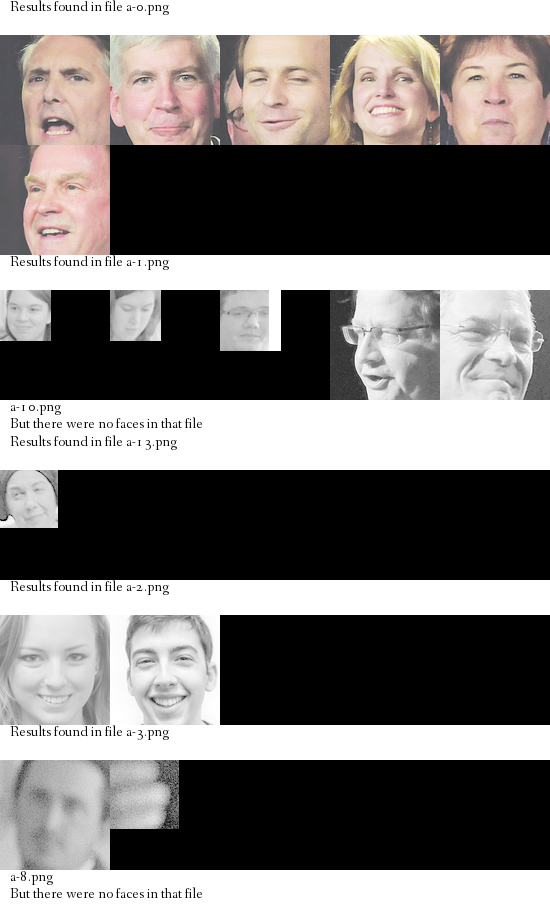

In [8]:
show_the_answer('readonly/images.zip')